# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [31]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [33]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [34]:
from cs231n.features import *

num_color_bins = 30 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [10]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM
import time


learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for i in learning_rates:
    for j in regularization_strengths:
        
        svm = LinearSVM()
        tic = time.time()
        svm.train(X_train_feats, y_train, learning_rate=i, reg=j,
                      num_iters=1200, verbose=False)
        toc = time.time()
        print('That took %fs' % (toc - tic))
        
        y_train_pred = svm.predict(X_train_feats)
        train_acc = np.mean(y_train == y_train_pred)
        print('training accuracy: %f' % (train_acc, ))
        
        y_val_pred = svm.predict(X_val_feats)
        val_acc = np.mean(y_val == y_val_pred)
        print('validation accuracy: %f' % (val_acc, ))
        
        results[(i,j)] = (train_acc, val_acc)
        
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

That took 4.050114s
training accuracy: 0.086082
validation accuracy: 0.089000
That took 3.933480s
training accuracy: 0.123184
validation accuracy: 0.129000
That took 4.545226s
training accuracy: 0.120347
validation accuracy: 0.105000
That took 4.322317s
training accuracy: 0.099551
validation accuracy: 0.080000
That took 4.365131s
training accuracy: 0.177510
validation accuracy: 0.178000
That took 4.413039s
training accuracy: 0.422122
validation accuracy: 0.424000
That took 3.294520s
training accuracy: 0.403714
validation accuracy: 0.394000
That took 2.890988s
training accuracy: 0.417918
validation accuracy: 0.419000
That took 2.746779s
training accuracy: 0.378347
validation accuracy: 0.402000
lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.086082 val accuracy: 0.089000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.123184 val accuracy: 0.129000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.120347 val accuracy: 0.105000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.0995

In [21]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.412


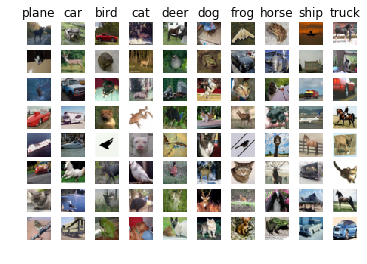

In [22]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [35]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 175)
(49000, 174)


In [41]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

best_net = None
best_acc = -1


learning_rates = [np.random.uniform() for i in range(5) ]
reg_sterngth = [10**np.random.uniform(-6,-7) for i in range(5)]

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


for  lr in [ 1e-3, 2e-3, 3e-3]:
    for reg_str in [ .2, .3 , .4]: 
        for h_size in [50,100,500]:
        
            net = TwoLayerNet(input_dim, h_size, num_classes)
            
            #train
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                                num_iters=1300, batch_size=200,
                                learning_rate=lr, learning_rate_decay=0.95,
                                reg=0.20, verbose=True)

            # validation/test
            val_acc = (net.predict(X_val_feats) == y_val).mean()

            if val_acc > best_acc:
                best_acc = val_acc
                best_net = net

            print("learning rate is {} \nreg_strength is {} \nh_size is {}".format(lr, reg_str , h_size))
            print('Validaiton accuracy: ', val_acc)
            
            test_acc = (best_net.predict(X_test_feats) == y_test).mean()
            print('Test accuracy: ', test_acc)
            print('Best accuracy: ', best_acc)
            print('////////////////////////////////////////////////////////////////////////////////////////')


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


iteration 0 / 1300: loss 2.302604
iteration 100 / 1300: loss 2.302592
iteration 200 / 1300: loss 2.302600
iteration 300 / 1300: loss 2.302633
iteration 400 / 1300: loss 2.302608
iteration 500 / 1300: loss 2.302553
iteration 600 / 1300: loss 2.302622
iteration 700 / 1300: loss 2.302648
iteration 800 / 1300: loss 2.302618
iteration 900 / 1300: loss 2.302623
iteration 1000 / 1300: loss 2.302653
iteration 1100 / 1300: loss 2.302525
iteration 1200 / 1300: loss 2.302585
learning rate is 0.001 
 reg_strength is 0.2 
 h_size is 50
Validaiton accuracy:  0.079
Test accuracy:  0.1
Best accuracy:  0.079
////////////////////////////////////////////////////////////////////////////////////////
iteration 0 / 1300: loss 2.302623
iteration 100 / 1300: loss 2.302629
iteration 200 / 1300: loss 2.302644
iteration 300 / 1300: loss 2.302628
iteration 400 / 1300: loss 2.302627
iteration 500 / 1300: loss 2.302658
iteration 600 / 1300: loss 2.302659
iteration 700 / 1300: loss 2.302643
iteration 800 / 1300: loss

iteration 200 / 1300: loss 2.302613
iteration 300 / 1300: loss 2.302606
iteration 400 / 1300: loss 2.302537
iteration 500 / 1300: loss 2.302609
iteration 600 / 1300: loss 2.302620
iteration 700 / 1300: loss 2.302574
iteration 800 / 1300: loss 2.302588
iteration 900 / 1300: loss 2.302627
iteration 1000 / 1300: loss 2.302589
iteration 1100 / 1300: loss 2.302633
iteration 1200 / 1300: loss 2.302668
learning rate is 0.002 
 reg_strength is 0.3 
 h_size is 50
Validaiton accuracy:  0.078
Test accuracy:  0.103
Best accuracy:  0.112
////////////////////////////////////////////////////////////////////////////////////////
iteration 0 / 1300: loss 2.302622
iteration 100 / 1300: loss 2.302597
iteration 200 / 1300: loss 2.302619
iteration 300 / 1300: loss 2.302662
iteration 400 / 1300: loss 2.302659
iteration 500 / 1300: loss 2.302594
iteration 600 / 1300: loss 2.302597
iteration 700 / 1300: loss 2.302520
iteration 800 / 1300: loss 2.302690
iteration 900 / 1300: loss 2.302600
iteration 1000 / 1300:

iteration 200 / 1300: loss 2.302715
iteration 300 / 1300: loss 2.302468
iteration 400 / 1300: loss 2.302778
iteration 500 / 1300: loss 2.302480
iteration 600 / 1300: loss 2.302661
iteration 700 / 1300: loss 2.302545
iteration 800 / 1300: loss 2.302508
iteration 900 / 1300: loss 2.302458
iteration 1000 / 1300: loss 2.302703
iteration 1100 / 1300: loss 2.302672
iteration 1200 / 1300: loss 2.302576
learning rate is 0.003 
 reg_strength is 0.4 
 h_size is 50
Validaiton accuracy:  0.087
Test accuracy:  0.103
Best accuracy:  0.112
////////////////////////////////////////////////////////////////////////////////////////
iteration 0 / 1300: loss 2.302623
iteration 100 / 1300: loss 2.302574
iteration 200 / 1300: loss 2.302635
iteration 300 / 1300: loss 2.302551
iteration 400 / 1300: loss 2.302637
iteration 500 / 1300: loss 2.302520
iteration 600 / 1300: loss 2.302893
iteration 700 / 1300: loss 2.302573
iteration 800 / 1300: loss 2.302465
iteration 900 / 1300: loss 2.302542
iteration 1000 / 1300:

In [42]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.103
